# Reduced fragment library

## Aim of this notebook

The fragment library resulting from the KinFragLib fragmentation procedure comprises of about 3000 fragments. Ultimately, we want to demonstrate how this library can be used for recombining ligands. Before this can be done, we need to address two considerations:

1. Remove all fragments that are not useful in a recombination, i.e. duplicates, fragments in pool X, fragments without dummy atoms, and fragments with dummy atoms only connecting to pool X. Also remove all AP fragments that show no hydrogen bond donors and acceptors (not hinge-like).
2. Select a diverse set of fragments (per subpocket) for recombination to (i) save computational cost and (ii) avoid recombination of highly similar fragments.

Furthermore, we want to know (i) which original ligands can be fully recombined by the reduced fragment library and (ii) how many original ligands are represented by at least one fragment. This will help us to check our combinatorial library for expected results later.

## Table of contents

1. Load fragment library
2. Filter fragment library
3. Cluster and select filtered fragments (get diverse set of fragments)
4. Look at selected fragments
5. Selected fragments = reduced fragment library
6. How many ligands are (fully) covered by the reduced library?
7. Save reduced fragment library 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from pathlib import Path

import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Lipinski, PandasTools

from utils import *

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

## Globals

In [4]:
# Path to data
PATH_DATA = Path('.') / '..' / 'data'

# Butina clustering: distance cutoff
DISTANCE_CUTOFF = 0.6

# Select fragments from clusters: Most common fragment per cluster (if mulitple most common fragments, select the one most similar to cluster centroid)
# (A) Select always one fragment per cluster (cluster centroid)
#N_REPRESENTED_FRAGMENTS = None
# (B) Select top X most common fragments per cluster, whereby X is depending on cluster size (20 clustered fragments will be represented by one selected fragment)
N_REPRESENTED_FRAGMENTS = 10

# Do we want to include fragment from singleton clusters?
INCLUDE_SINGLETONS = True

## 1. Load fragment library

In [5]:
fragment_library = read_fragment_library(PATH_DATA / 'fragment_library')

(7486, 15)


,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
0,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,Nc1c[nH]c2ncccc12,[11*]c1cnc2[nH]cc(N[27*])c2c1,AP
1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,AP

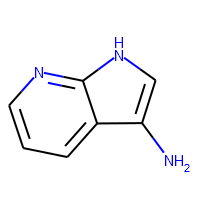
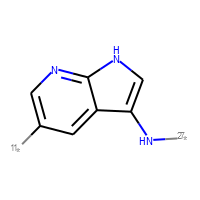
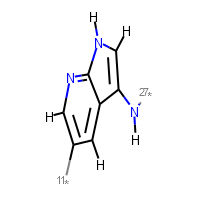
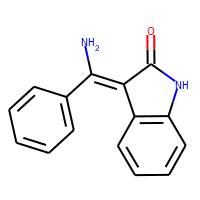
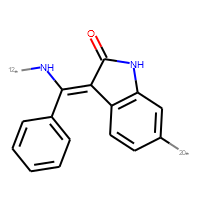
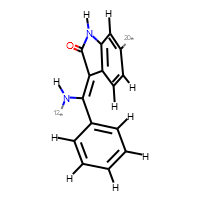

In [6]:
fragment_library_concat = pd.concat(fragment_library).reset_index(drop=True)
print(fragment_library_concat.shape)
fragment_library_concat.head(2)

In [7]:
fragment_library_concat.groupby('subpocket', sort=False).size()

subpocket
AP    2561
FP    1866
SE    1560
GA    1024
B1      98
B2      92
X      285
dtype: int64

## 2. Filter fragment library

Filter steps:

1. Remove pool X
2. Deduplicate fragment library (per subpocket)
3. Remove fragments without dummy atoms (unfragmented ligands)
4. Remove all fragments that connect only to pool X
5. Keep "Rule of Three (Ro3)" compliant fragments (fragment-likeness)
6. Filter AP subpocket fragments (typical hinge-like)

### 2.1. Remove pool X

In [8]:
# Remove pool X
fragment_library_concat_filtered = fragment_library_concat[
    fragment_library_concat.subpocket != 'X'
].copy()
print(fragment_library_concat_filtered.shape)
fragment_library_concat_filtered.subpocket.unique()

(7201, 15)


array(['AP', 'FP', 'SE', 'GA', 'B1', 'B2'], dtype=object)

### 2.2. Deduplicate fragment library (per subpocket)

In [9]:
# Get fragment count (by SMILES) per subpocket
fragment_count = fragment_library_concat_filtered.groupby(
    ['subpocket', 'smiles'],
    sort=False
).size()

In [10]:
# Get first occurrence of SMILES per subpocket
fragment_library_concat_filtered = fragment_library_concat_filtered.groupby(
    ['subpocket', 'smiles'],
    sort=False
).first()

(2977, 16)


,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3

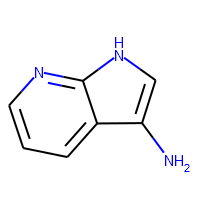
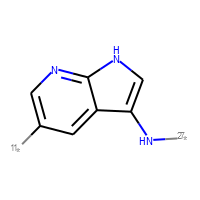
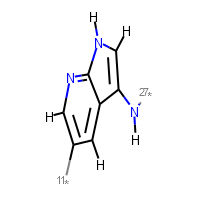
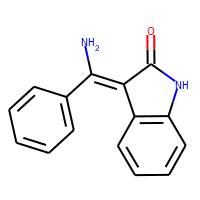
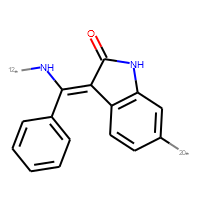
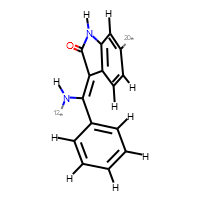

In [11]:
# Add fragment count to these representative fragments
fragment_library_concat_filtered['fragment_count'] = fragment_count
fragment_library_concat_filtered.reset_index(inplace=True)

print(fragment_library_concat_filtered.shape)
fragment_library_concat_filtered.head(2)

In [12]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()

subpocket
AP    1115
FP     864
SE     607
GA     306
B1      42
B2      43
dtype: int64

### 2.3. Remove fragments without dummy atoms (unfragmented ligands)

In [13]:
# Get fragments' (subpocket) connections 
fragment_library_concat_filtered['connections'] = get_connections_by_fragment(fragment_library_concat_filtered).connections

In [14]:
# Unfragmented ligands?
bool_unfragmented_ligands = fragment_library_concat_filtered.connections.apply(lambda x: len(x) == 0)

In [15]:
# Remove unfragmented ligands
fragment_library_concat_filtered = fragment_library_concat_filtered[
    ~bool_unfragmented_ligands
].copy()
print(fragment_library_concat_filtered.shape)

(2863, 18)


In [16]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()

subpocket
AP    1001
FP     864
SE     607
GA     306
B1      42
B2      43
dtype: int64

### 2.4. Remove all fragments that connect only to pool X

In [17]:
# Fragment connects only to pool X?
bool_only_pool_x_connections = fragment_library_concat_filtered.connections.apply(
    lambda x: all(  # All connections per fragment are X?
        [True if 'X' in i else False for i in x]  # Connections per fragment X or not?
    )
)

In [18]:
# Remove fragments that connect only to pool X
fragment_library_concat_filtered = fragment_library_concat_filtered[
    ~bool_only_pool_x_connections
].copy()
print(fragment_library_concat_filtered.shape)

(2862, 18)


In [19]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()

subpocket
AP    1001
FP     864
SE     607
GA     306
B1      42
B2      42
dtype: int64

### 2.5. Keep "Rule of Three (Ro3)" compliant fragments (fragment-likeness)

Rule of Three criteria ([paper](https://www.sciencedirect.com/science/article/pii/S1359644603028319)):
- Molecular weight < 300 Da
- LogP <= 3
- Number of HBA <= 3 
- Number of HBD <= 3
- Number of rotatable bonds <= 3 
- Polar surface area (PSA) <= 60 $\mathring{A}$<sup>2</sup>

In [ ]:
ro3 = fragment_library_concat_filtered.ROMol.apply(lambda x: get_ro3_from_mol(x))

In [ ]:
# Fragments fulfill all six Ro3 rules
bool_fulfill_ro3 = ro3.sum(axis=1) == 6

In [ ]:
fragment_library_concat_filtered = fragment_library_concat_filtered[
    bool_fulfill_ro3
].copy()
print(fragment_library_concat_filtered.shape)

In [ ]:
fragment_library_concat_filtered.groupby('subpocket', sort=False).size()

### 2.6. Filter AP subpocket fragments (typical hinge-like)

For the AP subpocket, we only want to keep fragments that (similar to most '-nibs') have 
- at least one hydrogen bond donor (HBD) or acceptor (HBA) and
- at least one aromatic or aliphatic ring.

1. Add the number of HBD, HBA, (heavy atoms), aromatic and aliphatic rings for all fragments - use fragments with dummy atoms to avoid detection of HBDs at dummy atom neighboring atoms.

In [ ]:
fragment_library_concat_filtered['hbd'] = fragment_library_concat_filtered.ROMol_dummy.apply(lambda x: Lipinski.NumHAcceptors(x))
fragment_library_concat_filtered['hba'] = fragment_library_concat_filtered.ROMol_dummy.apply(lambda x: Lipinski.NumHDonors(x))
fragment_library_concat_filtered['n_atoms'] = fragment_library_concat_filtered.ROMol_dummy.apply(lambda x: x.GetNumHeavyAtoms())
fragment_library_concat_filtered['n_aromatic_rings'] = fragment_library_concat_filtered.ROMol_dummy.apply(lambda x: Lipinski.NumAromaticRings(x))
fragment_library_concat_filtered['n_aliphatic_rings'] = fragment_library_concat_filtered.ROMol_dummy.apply(lambda x: Lipinski.NumAliphaticRings(x))

In [ ]:
def draw_fragments_with_hinge_criteria_annotation(fragments, max_mols):
    """
    Draw fragments labeled with their number of HBDs, HBAs, aromatic and aliphatic rings.
    
    Parameters
    ----------
    fragments : pandas.DataFrame
        Fragments in DataFrame with columns ROMol_dummy (RDKit molecule with dummy atoms), hbd, hba, n_aromatic_rings, n_aliphatic_rings 
        (number of HBDs, HBAs, aromatic and aliphatic rings rings).
    max_mols : int
        Number of molecules displayed.
        
    Returns
    -------
    PIL.PngImagePlugin.PngImageFile
        Image of fragments.
    """
    
    if fragments.shape[0] == 0:
        raise ValueError(f'Input DataFrame has length 0 - no data available to be drawn.')
    
    print(f'#HBD | #HBA | #aromatic rings | #aliphatic rings | complex PDB ID | ligand PDB ID')
    image = Draw.MolsToGridImage(
        fragments.ROMol_dummy,
        maxMols=max_mols,
        molsPerRow=7,
        legends=fragments.apply(
            lambda x: f'{x.hbd} | {x.hba} | {x.n_aromatic_rings} | {x.n_aliphatic_rings} | {x.complex_pdb} | {x.ligand_pdb}',
            axis=1
        ).to_list()
    )
    
    return image

In [ ]:
print('Example AP fragments with hinge criteria annotation (in order to check if number of HBA ect. are as expected:)')
draw_fragments_with_hinge_criteria_annotation(fragment_library_concat_filtered[fragment_library_concat_filtered.subpocket == 'AP'], max_mols=14)

2. Get index labels for fragments that do not show any HBDs, HBAs, aromatic and aliphatic rings.

In [ ]:
index_labels_hinge_unlike = fragment_library_concat_filtered[
    (fragment_library_concat_filtered.subpocket == 'AP') & 
    ((fragment_library_concat_filtered.hbd + fragment_library_concat_filtered.hba == 0) | 
    (fragment_library_concat_filtered.n_aromatic_rings + fragment_library_concat_filtered.n_aliphatic_rings == 0))
].index

print('Fragments that will be filtered out:')
draw_fragments_with_hinge_criteria_annotation(fragment_library_concat_filtered.loc[index_labels_hinge_unlike], max_mols=50)

Verify these filtered-out AP fragments (focus on those with H-bonds possibility only) by checking all fragments and annotated subpockets of the original ligand as well as it's interactions in KLIFS's 3D view to assess if the ligands really should not be considered for library design:

- Ligand has no typical hinge fragment  
  - 5m44  
  - 6hop  
  - 6hot  
  - 5yv9  
  - 4yth  
  - 5ar5  
- Ligand contains large 'not fragmentable' part
  - 5omy: FP fragment contains AP part  
  - 5w5v: SE fragment contains AP part  
- Corner cases: AP fragment is not correctly assigned (due to design choices) 
  - 3fdn: SE contains hinge binding fragment (visual inspection)  
  - 4uyn: GA contains part of hinge binding fragment (visual inspection)  
  - 4o0y: Ligand has two AP fragments (allowed in current implementation) of which one is the intended one, the one that is filtered out here is rather part of SE  

In [ ]:
# Look at ligand fragmentation like this:
draw_fragmented_ligand(fragment_library, '5w5v', 'ANW')

3. Drop these hinge-unlike fragments in AP.

In [ ]:
fragment_library_concat_filtered.drop(
    labels=index_labels_hinge_unlike, 
    axis=0,
    inplace=True
)
fragment_library_concat_filtered.shape

## 3. Cluster and select filtered fragments (get diverse set of fragments)

### Fragment clustering per subpocket

In [ ]:
def cluster_fragments(fragments, cutoff):
    """
    Cluster fragments using the Butina algorithm with a given distance cutoff.
    
    Parameters
    ----------
    fragments : pandas.DataFrame
        Fragments.
    cutoff : float
        Distance cutoff Butina clustering.
        
    Returns
    -------
    pandas.DataFrame
        Clustered fragments, containing fragment details available from input plus cluster details (fragments' cluster IDs, cluster member ID, 
        cluster size, and molecule ID).
    """

    # Get fragments by subpocket
    fragments = fragments.copy()
    fragments.reset_index(inplace=True, drop=True)
    fragments.index.name = 'molecule_id'

    # Cluster molecules 
    clustered_fragments = cluster_molecules(fragments.ROMol, cutoff)
    #clustered_fragments = cluster_molecules(fragments.ROMol_dummy, cutoff)  # (including dummy atoms)
    
    # Concatenate cluster metadata with fragment details
    clustered_fragments = fragments.merge(
        clustered_fragments,
        on='molecule_id',
    )
    
    return clustered_fragments

### Fragment selection per subpocket

In [ ]:
def select_fragments_from_clusters(clustered_fragments, n_represented_fragments=None):
    """
    Select fragments from clusters - two options: 
    (A) Get most common fragment. In case of mulitple most common fragments, select the one that is most similar to cluster centroid.
    (B) Get top X most common fragments, whereby X depends on the cluster size (more fragments will be selected from larger clusters).
    
    Parameters
    ----------
    clustered_fragments : pandas.DataFrame
        Fragments with cluster details (cluster ID, cluster size, cluster member ID, and molecule ID).
    n_represented_fragments : None or int
        Default: Select first fragment per sorted cluster (None). 
        Alternative: Select top X fragments per sorted cluster, whereby X depends on cluster size (n_cluster_fragments): 
        X = n_cluster_fragments / n_represented_fragments.
        
    Returns
    -------
    pandas.DataFrame
        Fragments selected from clusters, including cluster IDs, cluster member ID, cluster size, and molecule ID.
    """
    
    # Sort DataFrame by cluster ID (ascending), fragment count (descending), and cluster member ID (ascending)
    # Note member ID: the smaller, the more similar to cluster centroid
    clustered_fragments.sort_values(
        ['cluster_id', 'fragment_count', 'cluster_member_id'], 
        ascending=[True, False, True], 
        inplace=True
    )

    # Select fragment per cluster by (i) fragment count and (i) similarity to cluster centroids (cluster member ID):
    
    # Option A: Select first fragment per sorted cluster
    if n_represented_fragments is None:
        selected_fragments = clustered_fragments.groupby('cluster_id', sort=False).first()
        selected_fragments.reset_index(inplace=True)
        selected_fragments['cluster_size'] = clustered_fragments.groupby('cluster_id', sort=False).size()
    
    # Option B: Select top X fragments per sorted cluster, whereby X depends on the cluster size (e.g. per 20 fragments select one)
    else:
        selected_fragments = clustered_fragments.groupby('cluster_id', sort=False).apply(
            lambda x: x.head(math.ceil(len(x) / n_represented_fragments))
        )
        selected_fragments.reset_index(inplace=True, drop=True)
        selected_fragments['cluster_size'] = [clustered_fragments.groupby('cluster_id', sort=False).size().loc[cluster_id] for cluster_id in selected_fragments.cluster_id]
    
    print(f'Number of selected fragments / clusters / inital fragments: {selected_fragments.shape[0]} / {clustered_fragments.cluster_id.unique().shape[0]} / {clustered_fragments.shape[0]}')
    
    return selected_fragments

### Fragment clustering and selection for all subpockets (individually)

In [ ]:
def select_fragments_from_clusters_all_subpockets(fragment_library_concat, cutoff, n_represented_fragments=None):
    """
    Cluster fragments and select cluster representatives for mulitple subpockets individually:
    1. Cluster fragments using the Butina algorithm with a given distance cutoff.
    2. Select fragments from clusters - two options: 
       (A) Get most common fragment. In case of mulitple most common fragments, select the one that is most similar to cluster centroid.
       (B) Get top X most common fragments, whereby X depends on the cluster size (more fragments will be selected from larger clusters).
    
    Parameters
    ----------
    fragment_library_concat : pandas.DataFrame
        Fragment library data for one or multiple subpockets.
    cutoff : float
        Distance cutoff Butina clustering.
    n_represented_fragments : None or int
        Default: Select first fragment per sorted cluster (None). 
        Alternative: Select top X fragments per sorted cluster, whereby X depends on cluster size (n_cluster_fragments): 
        X = n_cluster_fragments / n_represented_fragments.
    
    Returns
    -------
    pandas.DataFrame
        Fragments selected from clustering, including cluster IDs, cluster member ID, cluster size, and molecule ID (clustering per subpocket individually).   
    """
    
    selected_fragments_subpockets = {}

    for subpocket, fragments in fragment_library_concat.groupby('subpocket', sort=False):
        
        print(f'\nSubpocket: {subpocket}')
        
        clustered_fragments_subpocket = cluster_fragments(fragments, cutoff)
        selected_fragments_subpocket = select_fragments_from_clusters(clustered_fragments_subpocket, n_represented_fragments)
        
        selected_fragments_subpocket['subpocket'] = subpocket
        selected_fragments_subpockets[subpocket] = selected_fragments_subpocket

    # Concatenate cluster centroids for all subpockets
    selected_fragments = pd.concat(selected_fragments_subpockets).reset_index(drop=True)
    
    return selected_fragments

In [ ]:
selected_fragments = select_fragments_from_clusters_all_subpockets(
    fragment_library_concat_filtered, 
    DISTANCE_CUTOFF, 
    n_represented_fragments=N_REPRESENTED_FRAGMENTS
)

### Plot cluster sizes per subpocket

In [ ]:
# Get cluster size per subpocket and cluster
cluster_data = selected_fragments.groupby(
    ['subpocket', 'cluster_id']
).first()['cluster_size'].reset_index()

# Reformat cluster data for plotting (subpocket per column)
cluster_data = pd.concat(
    [
        subpocket_data.set_index('cluster_id')['cluster_size'] 
        for subpocket, subpocket_data 
        in cluster_data.groupby('subpocket', sort=False)
    ], 
    axis=1
)
cluster_data.columns = selected_fragments.groupby('subpocket', sort=False).groups.keys()

# Plot cluster data
cluster_data.plot(figsize=(15,5), title='Cluster numbers and sizes per subpocket')

### Include singletons?

In [ ]:
print(f'Number of selected fragments with singletons: {selected_fragments.shape[0]}')

if INCLUDE_SINGLETONS:
    pass
else:
    selected_fragments = selected_fragments[selected_fragments.cluster_size!=1]
    print(f'Number of selected fragments without singletons: {selected_fragments.shape[0]}')
    
print(f'Include singletons: {INCLUDE_SINGLETONS}')
print(f'Number of selected fragments in final set: {selected_fragments.shape[0]}')

## 4. Look at selected fragments

### Number of fragments per subpocket and in total

In [ ]:
selected_fragments.groupby('subpocket', sort=False).size()

In [ ]:
print(f'Size of reduced fragment library: {selected_fragments.shape[0]}')

In [ ]:
def draw_selected_fragments(selected_fragments, output_path=None):
    """
    Draw selected fragments sorted by descending cluster size (show legend cluster ID | cluster size | fragment count | cluster member ID).
    
    Parameters
    ----------
    cluster_centroids : pandas.DataFrame
        Fragments that are cluster centroids (cluster ID as index, molecule ID, cluster size, and ROMol).   
    output_path : pathlib.Path
        Path to output folder.
    
    Returns
    -------
    PIL.PngImagePlugin.PngImageFile
        Image of fragments sorted by descending cluster size.
    """
    
    subpocket = selected_fragments.subpocket.unique()[0]
        
    img = Draw.MolsToGridImage(
        list(selected_fragments.ROMol), 
        legends=[
            f'{row.cluster_id} | {row.cluster_size} | {row.fragment_count} | {row.cluster_member_id} | {row.complex_pdb} | {row.ligand_pdb}' 
            for index, row
            in selected_fragments.iterrows()
        ],  
        molsPerRow=7, 
        maxMols=200,
        subImgSize=(170, 170),
        useSVG=True
    )
    
    print(f'Legend: cluster ID | cluster size | fragment count | cluster member ID | complex PDB ID | ligand PDB ID')
    
    if output_path is not None:
        
        # Get SVG data
        molsvg = img.data

        # Set font size
        molsvg = molsvg.replace('12px', '24px');

        # Save altered SVG data to file
        with open(Path(output_path) / f'clustered_most_common_fragments_{subpocket.lower()}.svg', 'w') as f:
            f.write(molsvg)
    
    return img

### Fragments in AP

In [ ]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('AP'), output_path=None)

### Fragments in FP

In [ ]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('FP'), output_path=None)

### Fragments in SE

In [ ]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('SE'), output_path=None)

### Fragments in GA

In [ ]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('GA'), output_path=None)

### Fragments in B1

In [ ]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('B1'), output_path=None)

### Fragments in B2

In [ ]:
draw_selected_fragments(selected_fragments.groupby('subpocket').get_group('B2'), output_path=None)

## 5. Selected fragments = reduced fragment library

After looking at all selected fragments and being content with the results, we define this set as reduced fragment library.

In [ ]:
fragment_library_concat_reduced = selected_fragments

## 6. How many ligands are (fully) covered by the reduced library?

Loop over each subpocket pool in the full library and ask for each fragment if it is part of the respective reduced library's subpocket pool?

In [ ]:
def _add_in_reduced_library_column(fragment_library, fragment_library_concat_reduced):
    """
    Take fragment library and add per subpocket pool an additional column stating if each fragment is part of the reduced fragment library.
    Fragments in the full library are considered to be part of the reduced library if
    - they match a SMILES in the reduced library (in the same subpocket),
    - they match in atom enviroments, i.e. atoms have the same BRICS rules, (in the same subpocket), and
    - they match in atom subpockets, i.e. atoms are assigned to the same subpocket, especially dummy atoms match also (in the same subpocket).
    
    Parameters
    ----------
    fragment_library : dict of pandas.DataFrame
        Fragment details, i.e. SMILES, and fragment RDKit molecules, KLIFS and fragmentation details (values)
        for each subpocket (key).
    fragment_library_concat_reduced : pandas.DataFrame
        Reduced fragment library data for one or multiple subpockets.
    
    Returns
    -------
    dict of pandas.DataFrame
        Fragment details, i.e. SMILES, and fragment RDKit molecules, KLIFS and fragmentation details AND column on if fragment is part of reduced library(values)
        for each subpocket (key).
    """
    
    fragment_library_tmp = fragment_library.copy()
    
    for subpocket, fragments in fragment_library_tmp.items():

        fragments['subpocket'] = subpocket

        if subpocket != 'X':

            fragments_reduced = fragment_library_concat_reduced.groupby('subpocket', sort=False).get_group(subpocket)

            smiles_match = fragments.smiles.isin(fragments_reduced.smiles)
            atom_environments_match = fragments.atom_environments.isin(fragments_reduced.atom_environments)
            atom_subpockets_match = fragments.atom_subpockets.isin(fragments_reduced.atom_subpockets)
            fragments['in_reduced_library'] = smiles_match & atom_environments_match & atom_subpockets_match
        else:
            fragments['in_reduced_library'] = False
            
    print(f'How many fragments are in reduced library?')
    print(fragment_library_concat_reduced.shape[0])

    print(f'How many fragments in full library are covered by reduced library?')
    print(pd.concat(fragment_library).in_reduced_library.sum())
    
    return fragment_library_tmp

Check if original ligand (from full fragment library) is in parts or fully covered by our reduced fragment library.

In [ ]:
def get_ligand_coverage_in_reduced_library(fragment_library, fragment_library_concat_reduced):
    """
    Get original ligands (based on full fragment library) with information if each ligand is 
    (i) covered at all or (ii) covered fully by fragments in the reduced fragment library.
    
    Parameters
    ----------
    fragment_library : dict of pandas.DataFrame
        Fragment details, i.e. SMILES, and fragment RDKit molecules, KLIFS and fragmentation details (values)
        for each subpocket (key).
    fragment_library_concat_reduced : pandas.DataFrame
        Reduced fragment library data for one or multiple subpockets.
    
    Returns
    -------
    pandas.DataFrame
        Original ligands with information if each ligand is (i) covered at all or (ii) covered fully by fragments in the reduced fragment library.
    """
    
    fragment_library_tmp = _add_in_reduced_library_column(fragment_library, fragment_library_concat_reduced)
    
    # Group fragment library by kinase, complex and ligands to get all original ligands
    original_ligands_groups = pd.concat(fragment_library_tmp).groupby(['kinase', 'complex_pdb', 'ligand_pdb'], sort=False)

    # Is ligand fully covered, i.e. all fragments included (True or False)?
    bool_ligand_is_fully_covered = original_ligands_groups.apply(
        lambda ligand: all(ligand.in_reduced_library)
    )
    bool_ligand_is_fully_covered.name = 'is_fully_covered'

    # Is ligand covered with one or more fragments (True or False)?
    bool_ligand_is_covered = original_ligands_groups.apply(
        lambda ligand: any(ligand.in_reduced_library)
    )
    bool_ligand_is_covered.name = 'is_covered'

    # Make DataFrame
    original_ligands = pd.concat([
        bool_ligand_is_fully_covered, bool_ligand_is_covered],
        axis=1
    )
    original_ligands.reset_index(inplace=True)
    
    return original_ligands

In [ ]:
original_ligands = get_ligand_coverage_in_reduced_library(fragment_library, fragment_library_concat_reduced)

print(f'How many original ligands (from full fragment library?)')
original_ligands.shape[0]

In [ ]:
# Keep only fully covered ligands
original_ligands_fully_covered = original_ligands[original_ligands.is_fully_covered == True]

In [ ]:
print(f'Number of fragments in reduced library: {fragment_library_concat_reduced.shape[0]}')
print(f'Number of fully covered ligands by reduced library: {original_ligands_fully_covered.shape[0]}')

In [ ]:
draw_ligands_from_pdb_ids(
    list(original_ligands_fully_covered.complex_pdb), 
    list(original_ligands_fully_covered.ligand_pdb), 
    mols_per_row=6,
    max_mols=100
)

## 7. Save reduced fragment library

In [ ]:
# Create new folder for reduced fragment library
(PATH_DATA / 'fragment_library_reduced').mkdir(parents=True, exist_ok=True)

Save reduced fragment library as sdf files (one per subpocket).

In [ ]:
def save_reduced_fragment_library_to_sdfs(path_data, fragment_library_concat_reduced, cutoff):
    """
    Save reduced fragment library to file (for each subpocket sdf file, all in a newly (if not existing) created "fragment_library_reduced" folder).
    
    Parameters
    ----------
    path_data : str or pathlib.Path
        Path to data folder (containing folders for fragment library and reduced fragment library).
    fragment_library_concat_reduced : pandas.DataFrame
        Reduced fragment library data for one or multiple subpockets.
    cutoff : float
        Distance cutoff Butina clustering.
    """
    
    path_fragment_library_reduced = Path(path_data) / 'fragment_library_reduced'
    path_fragment_library_reduced.mkdir(parents=True, exist_ok=True)
    
    for subpocket, fragments in fragment_library_concat_reduced.groupby('subpocket'):
        
        with open(path_fragment_library_reduced / f'{subpocket}_reduced_{cutoff}.sdf', 'w') as f:
            w = Chem.SDWriter(f)
            for mol in fragments.ROMol_original:
                w.write(mol)
            w.close()